In [1]:
import sys
sys.path.append('C:\Anaconda3\Lib\site-packages')

import os
import pandas as pd
import numpy as np
from tqdm import *
import matplotlib.pyplot as plt
%matplotlib inline
import json

C:\Anaconda3\Lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [3]:
%load_ext snakeviz

## Predicting Groupo Bimbo inventory demands
Author: Alex Galea  
Date: August 17th, 2016

### Import data and set up features

In [176]:
%%time
types = {'Agencia_ID': np.uint16, 'Ruta_SAK':np.uint16,
         'Cliente_ID': np.uint32, 'Producto_ID':np.uint16}
#          'demand_w3': np.uint32 , 'demand_w4': np.uint32,
#          'demand_w5': np.uint32 , 'demand_w6': np.uint32,
#          'demand_w7': np.uint32 , 'demand_w8': np.uint32,
#          'demand_w9': np.uint32}

df = pd.read_csv('../input/train_features.csv',
                 usecols=list(types.keys())+\
                 'demand_w3 demand_w4 demand_w5 demand_w6 demand_w7 demand_w8 demand_w9'.split(),
                 dtype=types)
df.head()

Wall time: 38.1 s


Finding mean and log-transformed mean for demands in each row.

In [177]:
%%time
df['demand_mean'] = df.iloc[:, 4:11].\
                    apply(lambda x: np.mean(x),
                          axis=1)

Wall time: 13min 21s


In [178]:
%%time
df['demand_log_transform_mean'] = df.iloc[:, 4:11].\
    apply(lambda x: np.exp((np.log(x + 1)).mean()) - 1,
          axis=1)

Wall time: 51min 43s


In [179]:
df['demand_mean'] = df.demand_mean.apply(lambda x: np.round(x))
df['demand_log_transform_mean'] = df.demand_log_transform_mean.apply(lambda x: np.round(x))

In [181]:
# If it doesn't already exist, save a processed version of the dataframe
name = 'train_df_means.csv'
if not os.path.isfile('../input/'+name):
    df.to_csv('../input/'+name)

### Start here

In [4]:
# Can skip the above computations and load processed version of dataframe
if True:
    
    name = 'train_df_means.csv'
    
    types = {'Agencia_ID': np.uint16, 'Ruta_SAK': np.uint16,
             'Cliente_ID': np.uint32, 'Producto_ID': np.uint16}
#              'demand_w3': np.uint32 , 'demand_w4': np.uint32,
#              'demand_w5': np.uint32 , 'demand_w6': np.uint32,
#              'demand_w7': np.uint32 , 'demand_w8': np.uint32,
#              'demand_w9': np.uint32, 'demand_mean': np.uint32,
#              'demand_log_transform_mean': np.uint32,
#              'demand_mean_last2weeks': np.uint32,
#              'demand_mean_last3weeks': np.uint32,
#              'demand_mean_last4weeks': np.uint32,
#              'demand_log_mean_last4weeks': np.uint32,
#              'demand_log_mean_last5weeks': np.uint32,
#              'demand_log_mean_last6weeks': np.uint32}

    df = pd.read_csv('../input/'+name,
#                      usecols=list(types.keys()),
                     dtype=types, index_col='Unnamed: 0')
df.head()

,Agencia_ID,Ruta_SAK,Cliente_ID,Producto_ID,demand_w3,demand_w4,demand_w5,demand_w6,demand_w7,demand_w8,demand_w9,demand_mean,demand_log_transform_mean,demand_mean_last2weeks,demand_mean_last3weeks,demand_mean_last4weeks,demand_log_mean_last4weeks,demand_log_mean_last5weeks,demand_log_mean_last6weeks
0,1110,3301,15766,1211,3.0,4.0,5.0,NaN,NaN,4.0,1.0,3.0,3.0,2,3,4,3,3,3
1,1110,3301,15766,1216,4.0,2.0,3.0,1.0,2.0,5.0,NaN,3.0,3.0,4,3,3,2,2,3
2,1110,3301,15766,1238,4.0,3.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,2,2,2,2,2,2
3,1110,3301,15766,1240,4.0,7.0,NaN,NaN,8.0,2.0,2.0,5.0,4.0,2,4,5,4,4,4
4,1110,3301,15766,1242,3.0,3.0,2.0,3.0,2.0,1.0,1.0,2.0,2.0,1,1,2,2,2,2


Getting client means to use for new product predictions and overall mean for new clients. Should do this before inserting values for NaN.

In [6]:
%%time
# dict of client means combining all products and all weeks
dict_client_mean = df[['Cliente_ID', 'demand_log_transform_mean']].\
                    groupby(['Cliente_ID']).mean().\
                    apply(lambda x: np.round(x)).\
                    to_dict()['demand_log_transform_mean']

Wall time: 2.88 s


In [7]:
%%time
# dict of product means combining all clients and all weeks
dict_product_mean = df[['Producto_ID', 'demand_log_transform_mean']].\
                    groupby(['Producto_ID']).mean().\
                    apply(lambda x: np.round(x)).\
                    to_dict()['demand_log_transform_mean']

Wall time: 1.13 s


In [8]:
print(np.mean(list(dict_client_mean.values())))
print(np.mean(list(dict_product_mean.values())))

5.34379471363
47.7177777778


In [9]:
overall_mean = int(np.round(np.mean(list(dict_client_mean.values()))))
overall_mean

5

In [10]:
for key in dict_client_mean.keys():
    dict_client_mean[key] = int(dict_client_mean[key])
    
for key in dict_product_mean.keys():
    dict_product_mean[key] = int(dict_product_mean[key])

In [11]:
len(dict_client_mean)

880604

In [12]:
# Fill NaN entries with average for each product
# across all weeks (demand_mean column)
for i in range(4,11):
    df.iloc[:, i].fillna(df.demand_log_transform_mean, inplace=True)

In [13]:
df.head()

,Agencia_ID,Ruta_SAK,Cliente_ID,Producto_ID,demand_w3,demand_w4,demand_w5,demand_w6,demand_w7,demand_w8,demand_w9,demand_mean,demand_log_transform_mean,demand_mean_last2weeks,demand_mean_last3weeks,demand_mean_last4weeks,demand_log_mean_last4weeks,demand_log_mean_last5weeks,demand_log_mean_last6weeks
0,1110,3301,15766,1211,3.0,4.0,5.0,3.0,3.0,4.0,1.0,3.0,3.0,2,3,4,3,3,3
1,1110,3301,15766,1216,4.0,2.0,3.0,1.0,2.0,5.0,3.0,3.0,3.0,4,3,3,2,2,3
2,1110,3301,15766,1238,4.0,3.0,1.0,2.0,2.0,3.0,2.0,2.0,2.0,2,2,2,2,2,2
3,1110,3301,15766,1240,4.0,7.0,4.0,4.0,8.0,2.0,2.0,5.0,4.0,2,4,5,4,4,4
4,1110,3301,15766,1242,3.0,3.0,2.0,3.0,2.0,1.0,1.0,2.0,2.0,1,1,2,2,2,2


In [14]:
# Save the results of the above calculations
name = 'train_df_means_NaN_filled.csv'
df.to_csv('../input/'+name)

In [21]:
tmp_dict = {str(k): v for k, v in dict_client_mean.items()}
name = 'dict_client_mean.json'
with open('../input/'+name, 'w') as f:
    json.dump(tmp_dict, f)

tmp_dict = {str(k): v for k, v in dict_product_mean.items()}
name = 'dict_product_mean.json'
with open('../input/'+name, 'w') as f:
    json.dump(tmp_dict, f)
    
tmp_dict = {}

### Start here if you don't need to load NaNs (replaced by means)

In [2]:
# Can skip the above computations and load processed version of dataframe
if True:
    
    name = 'train_with_cnames_id_NaN_filled.csv'
    
    types = {'Agencia_ID': np.uint16, 'Ruta_SAK': np.uint16,
             'NombreCliente_id': np.uint8,
             'Cliente_ID': np.uint32, 'Producto_ID': np.uint16,
             # 'demand_w3': np.uint32 , 'demand_w4': np.uint32,
             'demand_w5': np.uint32, 'demand_w6': np.uint32,
             'demand_w7': np.uint32 , 'demand_w8': np.uint32,
             'demand_w9': np.uint32, #'demand_mean': np.uint32,
#              'demand_log_transform_mean': np.uint32,
#              'demand_mean_last2weeks': np.uint32,
#              'demand_mean_last3weeks': np.uint32,
#              'demand_mean_last4weeks': np.uint32,
#              'demand_log_mean_last4weeks': np.uint32,
#              'demand_log_mean_last5weeks': np.uint32,
             'demand_log_mean_last6weeks': np.uint32}

    df = pd.read_csv('../input/'+name,
                      usecols=list(types.keys()),
                     dtype=types)#, index_col='Unnamed: 0')
df.head()

,Agencia_ID,Ruta_SAK,Cliente_ID,Producto_ID,demand_w5,demand_w6,demand_w7,demand_w8,demand_w9,demand_log_mean_last6weeks,NombreCliente_id
0,1110,3301,15766,1211,5,3,3,4,1,3,11
1,1110,3301,15766,1216,3,1,2,5,3,3,11
2,1110,3301,15766,1238,1,2,2,3,2,2,11
3,1110,3301,15766,1240,4,4,8,2,2,4,11
4,1110,3301,15766,1242,2,3,2,1,1,2,11


In [3]:
name = 'dict_client_mean.json'
with open('../input/'+name, 'r') as f:
    dict_client_mean = json.load(f)

name = 'dict_product_mean.json'
with open('../input/'+name, 'r') as f:
    dict_product_mean = json.load(f)
    
dict_client_mean = {int(k): v for k, v in dict_client_mean.items()}
dict_product_mean = {int(k): v for k, v in dict_product_mean.items()}

In [4]:
overall_mean = 5

Get a slice of `df` where NaN rows in week 8 and 9 are removed (for training). _An alternate (better) method would be to keep NaNs in weeks 8 and 9 in `df` and deal with them during the prediction stage._ _This could take quite a lot longer though. In any case I want to avoid scoring my models on filled in (i.e. made up) target variables_ `y_true`.

In [95]:
df_train = df.dropna(subset=['demand_w8', 'demand_w9'])
# print(len(df_train)/len(df)*100, '% of rows remaining after drops')

Filling in NaN's of `df` and `df_train` slice.

In [12]:
%%time
# Fill NaN entries with average for each product
# across all weeks (demand_mean column)
for i in range(4,11):
    df.iloc[:, i].fillna(df.demand_mean, inplace=True)
    # df_train.iloc[:, i].fillna(df_train.demand_mean, inplace=True)

Wall time: 5.54 s


In [13]:
%%time
# Convert to integer and reduce memory cost
df.iloc[:, 4:13] = df.iloc[:, 4:13].astype(np.uint32)
# df_train.iloc[:, 4:13] = df_train.iloc[:, 4:13].astype(np.uint32)

Wall time: 1min 41s


In [14]:
# df_train.head()

In [15]:
df.head()

,Agencia_ID,Ruta_SAK,Cliente_ID,Producto_ID,demand_w3,demand_w4,demand_w5,demand_w6,demand_w7,demand_w8,demand_w9,demand_mean,demand_log_transform_mean
0,1110,3301,15766,1211,3,4,5,3,3,4,1,3,3
1,1110,3301,15766,1216,4,2,3,1,2,5,3,3,3
2,1110,3301,15766,1238,4,3,1,2,2,3,2,2,2
3,1110,3301,15766,1240,4,7,5,5,8,2,2,5,4
4,1110,3301,15766,1242,3,3,2,3,2,1,1,2,2


### Make predictions on weeks 8 and 9 using data from weeks 3-7
I took a slice (not a copy) of the entire dataframe `df` called `df_train` where the NaN rows from weeks 8 and 9 are removed. This will be used for evaluating model performance. For submissions, we'll use the entire data with NaN's filled for weeks 8 and 9.

In [187]:
features_i = range(4,9)
predict_i = range(9,11)

Predicting using __demand mean__ for given product and store.

In [188]:
p_w8_w9 = df_train.demand_mean.values

In [189]:
y_pred = np.vstack((p_w8_w9, p_w8_w9)).T
y_true = df_train.iloc[:,predict_i].values

In [190]:
def score_predictions(y_pred, y_true):
    ''' Input numpy arrays for the predictions and
    true labels that are the same size. Return the
    Root Mean Square Least Error RMSLE as defined
    by Kaggle: https://www.kaggle.com/c/grupo-bimbo-inventory-demand/details/evaluation.
    '''
    
    epsilon = 0
    for p, a in zip(y_pred.flatten(), y_true.flatten()):
        epsilon += (np.log(p + 1) - np.log(a + 1))**2
    
    return np.sqrt(epsilon/len(y_pred))

In [191]:
score = score_predictions(y_pred, y_true)
print('RMSLE score = {:.4f}'.format(score))

RMSLE score = 0.5307


Predicting using __log-transformed mean of demand__ (this minimizes the RMSLE).

In [192]:
%%time
p_w8_w9 = df_train.demand_log_transform_mean.values

y_pred = np.vstack((p_w8_w9, p_w8_w9)).T
y_true = df_train.iloc[:,predict_i].values

score = score_predictions(y_pred, y_true)
print('RMSLE score = {:.4f}'.format(score))

RMSLE score = 0.5098
Wall time: 1min 20s


### Making predictions for test set

In [10]:
types = {'Semana': np.uint8, #'Agencia_ID': np.uint16, 'Ruta_SAK': np.uint16,
         'Cliente_ID': np.uint32, 'Producto_ID':np.uint16}

df_test = pd.read_csv('../input/test.csv',
                      usecols=list(types.keys()),
                      dtype=types)
df_test.tail()

,Semana,Cliente_ID,Producto_ID
6999246,11,4379638,1232
6999247,10,970421,43069
6999248,11,192749,30532
6999249,11,286071,35107
6999250,11,978760,1232


In [11]:
len(df_test)/10**6

6.999251

Making a couple changes to `dict_client_mean` and `dict_product_mean` dictionaries before predictions.

In [12]:
# # Cap demand at max value of 30 as per previous exporation
# # which revealed 90% of demand is within this limit

# for k, v in dict_client_mean.items():
#     dict_client_mean[k] = np.min((v, 30))
    
# for k, v in dict_product_mean.items():
#     dict_product_mean[k] = np.min((v, 100))

In [47]:
# Add overall average values for missing clients
count = 0
for k in np.unique(df_test.Cliente_ID.values):
    if k not in dict_client_mean.keys():
        count += 1
        dict_client_mean[k] = overall_mean
print('Found %d new clients in test set' % count)

Found 9663 new clients in test set


In [48]:
# Add overall average values for missing products
count = 0
for k in np.unique(df_test.Producto_ID.values):
    if k not in dict_product_mean.keys():
        count += 1
        dict_product_mean[k] = overall_mean
print('Found %d new products in test set' % count)

Found 34 new products in test set


In [49]:
tmp_dict = {str(k): v for k, v in dict_client_mean.items()}
name = 'dict_client_mean.json'
with open('../input/'+name, 'w') as f:
    json.dump(tmp_dict, f)

tmp_dict = {str(k): v for k, v in dict_product_mean.items()}
name = 'dict_product_mean.json'
with open('../input/'+name, 'w') as f:
    json.dump(tmp_dict, f)
    
tmp_dict = {}

Creating a function to apply to `df_test` to get mean predictions from `df`.

In [48]:
def log_transform_mean_lookup(lookup_df, x, f, i):
    c_id, p_id = x
    try:
        val = lookup_df[(lookup_df.Cliente_ID == c_id)
                        &(lookup_df.Producto_ID == p_id)]\
             .demand_log_transform_mean[0]
    except:
        val = dict_client_mean[c_id]
        f.write(str(i)+','+str(int(val))+'\n')
    
    return int(val)

In [49]:
def write_submission(lookup_df, test_df, lookup_function, file, file2):
    f = open(file, 'w')
    f2 = open(file2, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(test_df.Cliente_ID,
                                              test_df.Producto_ID))):
        val = lookup_function(lookup_df,
                              (c_id, p_id), f2, i)
        f.write(str(i)+','+str(val)+'\n')
    f.close()
    f2.close()

In [50]:
%%snakeviz
write_submission(df[['Cliente_ID', 'Producto_ID',
                     'demand_log_transform_mean']],
                 df_test[:10], log_transform_mean_lookup,
                 'submission.csv', 'new_product_predictions.csv')

10it [00:01,  6.88it/s]

 
*** Profile stats marshalled to file 'C:\\Users\\agale\\AppData\\Local\\Temp\\tmpwqbgn6vx'. 


This is great and all, but it will take ~11 days to predict. The function below might be faster but who knows. I want to boost it up to about 100 it/s, which should take about 24 hours (i.e. a reasonable time) to predict.

In [ ]:
# %%time
# y_pred = df_test[['Cliente_ID', 'Producto_ID']]\
#             .apply(log_transform_mean_lookup, axis=1).values

Running the above computation without multithreading uses about 4.8 gigs of memory and 40% of CPU and takes AT LEAST 12 hours (at which point I stopped it).

Maybe it's reasonable to assign the __average of all products for each client__.

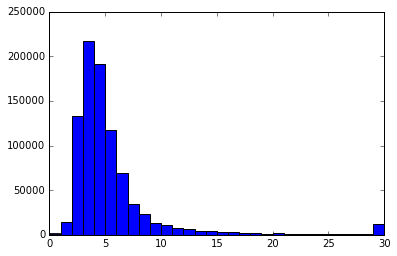

In [32]:
plt.hist(list(dict_client_mean.values()), bins=30);

In [62]:
def log_transform_mean_lookup_c(c_id):
    try:
        val = dict_client_mean[c_id]
    except:
        val = overall_mean
    return int(val)

def write_submission(df, lookup_function, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, c_id in tqdm(enumerate(df.Cliente_ID.values)):
        val = lookup_function(c_id)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

In [59]:
write_submission(df_test, log_transform_mean_lookup_c,
                 '../submissions/submission_1.csv')

6999251it [00:23, 299108.27it/s]


Alternatively, a simple solution is to assign the __average of each product for all clients__.

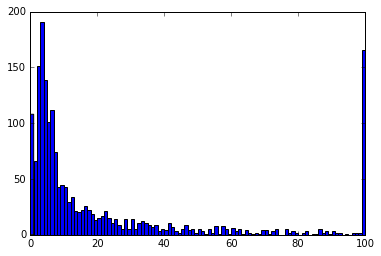

In [82]:
plt.hist(list(dict_product_mean.values()), bins=100);

In [83]:
def log_transform_mean_lookup_p(p_id):
    try:
        val = dict_product_mean[p_id]
    except:
        val = overall_mean
    return int(val)

def write_submission(df, lookup_function, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, p_id in tqdm(enumerate(df.Producto_ID.values)):
        val = lookup_function(p_id)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

In [84]:
write_submission(df_test, log_transform_mean_lookup_p,
                 '../submissions/submission_2.csv')

6999251it [00:19, 361052.11it/s]


How different are the two models?

In [85]:
y_client = df_test.Cliente_ID.apply(log_transform_mean_lookup_c)
y_product = df_test.Producto_ID.apply(log_transform_mean_lookup_p)

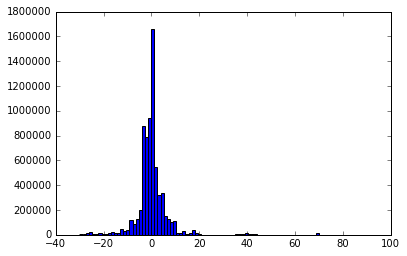

In [87]:
plt.hist(y_product-y_client, bins=100);

Lets create a model that knows about both. We'll __average the two with equal weights__ and round to the nearest integer.

In [93]:
def mean_lookup_p_c(x):
    p_id, c_id = x
    val = (dict_product_mean[p_id] + dict_client_mean[c_id])/2
    return int(np.round(val))

def write_submission(df, lookup_function, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (p_id, c_id) in tqdm(enumerate(zip(df.Producto_ID.values,
                                      df.Cliente_ID.values))):
        val = lookup_function((p_id, c_id))
        f.write(str(i)+','+str(val)+'\n')
    f.close()

In [94]:
write_submission(df_test, mean_lookup_p_c,
                 '../submissions/submission_3.csv')

6999251it [00:40, 170820.58it/s]


__TO DO:__ 

- reshape train dataframe to look like test dataframe
- make scoring function and compare to kaggle scores
- use ML algorithm to predict instead

In [ ]:
def score_submission(df, lookup_function):
#     y_true = df.
    
#     epsilon = 0
#     for p, a in zip(y_pred.flatten(), y_true.flatten()):
#         epsilon += (np.log(p + 1) - np.log(a + 1))**2
    
#     return np.sqrt(epsilon/len(y_pred))

It might be possible to __store the client + product combination in a dictionary__ for quick lookup.

In [15]:
def make_dict(df):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df.demand_mean)}
    return dict_client_product

In [16]:
%%time
dict_client_product_mean = make_dict(df)

Wall time: 1min 29s


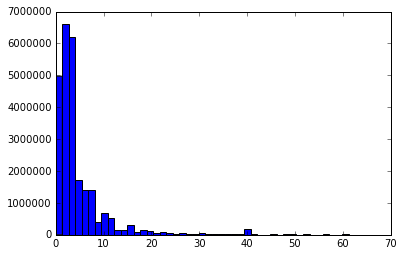

In [17]:
plt.hist(sorted(list(dict_client_product_mean.values()))[:-100000], bins=50);

Let's cap demand at 30 based on the figure above.

In [18]:
for k, v in dict_client_product_mean.items():
    dict_client_product_mean[k] = np.min((v, 30))

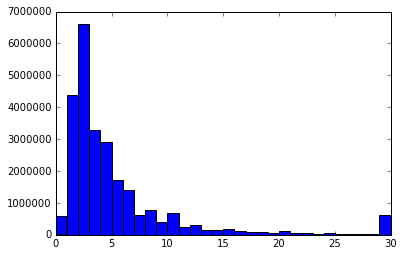

In [19]:
plt.hist(list(dict_client_product_mean.values()), bins=30);

Now I can predict using both __client and product combinations__.

In [55]:
def mean_lookup_p_and_c(x):
    c_id, p_id = x
    try:
        val = dict_client_product_mean[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                              df.Producto_ID.values))):
        val = lookup_function((c_id, p_id))
        f.write(str(i)+','+str(val)+'\n')
    f.close()

In [26]:
write_submission(df_test, mean_lookup_p_and_c,
                 '../submissions/submission_4.csv')

6999251it [00:54, 129263.96it/s]


Let's try __averaging only the last x number of weeks for each row__.

In [47]:
def get_recent_mean(x, num_weeks: int):
    ''' Get mean of most recent not NaN weeks
    as defined by num_weeks. '''
    val = np.round(np.mean(x.dropna()[-num_weeks:]))
    return int(val)

In [49]:
%%time
df['demand_mean_last2weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_mean(x, 2), axis=1)
df['demand_mean_last3weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_mean(x, 3), axis=1)
df['demand_mean_last4weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_mean(x, 4), axis=1)

Wall time: 10h 4min 4s


In [53]:
# Save the results of the above calculations
name = 'train_df_means.csv'
if not os.path.isfile('../input/'+name):
    df.to_csv('../input/'+name)

Creating submissions.

In [56]:
def make_dict(df, column):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df[column])}
    return dict_client_product

In [57]:
%%time
dict_last2weeks = make_dict(df, 'demand_mean_last2weeks')

def mean_lookup_p_and_c(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                              df.Producto_ID.values))):
        val = lookup_function((c_id, p_id), target_dict)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, mean_lookup_p_and_c, dict_last2weeks,
                 '../submissions/submission_5.csv')

6999251it [01:06, 105785.00it/s]

Wall time: 2min 52s


In [58]:
%%time
dict_last3weeks = make_dict(df, 'demand_mean_last3weeks')

def mean_lookup_p_and_c(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                              df.Producto_ID.values))):
        val = lookup_function((c_id, p_id), target_dict)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, mean_lookup_p_and_c, dict_last3weeks,
                 '../submissions/submission_6.csv')

6999251it [00:46, 151291.43it/s]

Wall time: 3min 17s


In [59]:
# Overwrite dicts to save space
dict_last2weeks = {}
dict_last3weeks = {}

In [60]:
%%time
dict_last4weeks = make_dict(df, 'demand_mean_last4weeks')

def mean_lookup_p_and_c(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                              df.Producto_ID.values))):
        val = lookup_function((c_id, p_id), target_dict)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, mean_lookup_p_and_c, dict_last4weeks,
                 '../submissions/submission_7.csv')

6999251it [00:49, 141970.61it/s]

Wall time: 3min 3s
Parser   : 161 ms


In [80]:
dict_client_product_mean = {}
dict_last4weeks = {}

Use log-means instead and check for improvement.

In [76]:
def get_recent_log_mean(x, num_weeks: int):
    ''' Get mean of most recent not NaN weeks
    as defined by num_weeks. '''
    val = np.round(np.exp((np.log(x.dropna()[-num_weeks:] + 1)).mean()) - 1)
    return int(val)

In [77]:
%%time
df['demand_log_mean_last4weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_log_mean(x, 4), axis=1)

Wall time: 3h 53min 14s


In [78]:
%%time
df['demand_log_mean_last5weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_log_mean(x, 5), axis=1)

Wall time: 3h 48min 56s


In [79]:
%%time
df['demand_log_mean_last6weeks'] = df.iloc[:, 4:11].apply(lambda x: get_recent_log_mean(x, 6), axis=1)

Wall time: 3h 46min 50s


In [81]:
%%time
dict_lastXweeks = make_dict(df, 'demand_log_mean_last4weeks')

def mean_lookup_p_and_c(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                              df.Producto_ID.values))):
        val = lookup_function((c_id, p_id), target_dict)
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, mean_lookup_p_and_c, dict_lastXweeks,
                 '../submissions/submission_8.csv')

6999251it [01:00, 116068.54it/s]

Wall time: 3min 7s


In [89]:
%%time
dict_lastXweeks = make_dict(df, 'demand_log_mean_last4weeks')

# Cap max at 200 and predict
for k, v in dict_lastXweeks.items():
    dict_lastXweeks[k] = np.min((v, 200))
    
write_submission(df_test, mean_lookup_p_and_c, dict_lastXweeks,
                 '../submissions/submission_9.csv')

6999251it [00:52, 132500.02it/s]

Wall time: 21min 40s


In [90]:
%%time
# Cap max at 30 and predict
for k, v in dict_lastXweeks.items():
    dict_lastXweeks[k] = np.min((v, 30))
    
write_submission(df_test, mean_lookup_p_and_c, dict_lastXweeks,
                 '../submissions/submission_10.csv')

6999251it [00:49, 141789.09it/s]

Wall time: 3min 1s


In [82]:
%%time
dict_lastXweeks = make_dict(df, 'demand_log_mean_last5weeks')

write_submission(df_test, mean_lookup_p_and_c, dict_lastXweeks,
                 '../submissions/submission_11.csv')

6999251it [01:48, 64603.28it/s] 

Wall time: 7min


In [83]:
%%time
dict_lastXweeks = make_dict(df, 'demand_log_mean_last6weeks')

write_submission(df_test, mean_lookup_p_and_c, dict_lastXweeks,
                 '../submissions/submission_12.csv')

6999251it [00:56, 124327.82it/s]

Wall time: 8min 29s
Parser   : 103 ms


In [91]:
# Save the results of the above calculations
name = 'train_df_means.csv'
if not os.path.isfile('../input/'+name):
    df.to_csv('../input/'+name)

## Implementing decision tree solutions
Ideas:
 - if memory is an issue, use (log) mean values for features e.g. previous week and mean (2 features) for each sample OR previous week, mean, and previous 4 weeks mean (3 features)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss
from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import StandardScaler

In [9]:
name = 'test.csv'

types = {#'Agencia_ID': np.uint16, 'Ruta_SAK': np.uint16,
         'Semana': np.uint8, #'NombreCliente_id': np.uint8,
         'Cliente_ID': np.uint32, 'Producto_ID': np.uint16}
#         'demand_w3': np.uint32 , 'demand_w4': np.uint32,
#         'demand_w5': np.uint32, #'demand_w6': np.uint32, 'demand_w7': np.uint32 ,
#         'demand_w8': np.uint32,
#         'demand_w9': np.uint32, #'demand_mean': np.uint32,
#              'demand_log_transform_mean': np.uint32,
#              'demand_mean_last2weeks': np.uint32,
#              'demand_mean_last3weeks': np.uint32,
#              'demand_mean_last4weeks': np.uint32,
#              'demand_log_mean_last4weeks': np.uint32,
#              'demand_log_mean_last5weeks': np.uint32,
#         'demand_log_mean_last6weeks': np.uint32}

df_test = pd.read_csv('../input/'+name,
                    usecols=list(types.keys()),
                    dtype=types)#, index_col='Unnamed: 0')
df_test.head()

,Semana,Cliente_ID,Producto_ID
0,11,4639078,35305
1,11,4705135,1238
2,10,4549769,32940
3,11,4717855,43066
4,11,966351,1277


___
Use training dataframe with NaNs from week 8 removed (don't want to train on made-up target variables).

In [16]:
df_train = df.dropna(subset=['demand_w8'])
print(len(df_train)/len(df)*100, '% of rows remaining after drops')

39.431353007334415 % of rows remaining after drops


In [17]:
def get_features(df, features, target):
    ''' Fill NaNs in the dataframe and return numpy array of values. '''
    for i in features:
        df.iloc[:, i].fillna(df.demand_log_transform_mean, inplace=True)
    return df.iloc[:, features].values, df[target]

In [19]:
for i, n in enumerate(df.columns):
    print(i, n)

0 Agencia_ID
1 Ruta_SAK
2 Cliente_ID
3 Producto_ID
4 demand_w3
5 demand_w4
6 demand_w5
7 demand_w6
8 demand_w7
9 demand_w8
10 demand_w9
11 demand_mean
12 demand_log_transform_mean
13 demand_mean_last2weeks
14 demand_mean_last3weeks
15 demand_mean_last4weeks
16 demand_log_mean_last4weeks
17 demand_log_mean_last5weeks
18 demand_log_mean_last6weeks


### Random forest of x decision trees
Using x = 5 and getting poor results. Lower Kaggle score (root mean squared logarithmic error) than work above which is bottom 33% of the leaderboard.

For more info on the scoring metric go to: https://www.kaggle.com/wiki/RootMeanSquaredLogarithmicError

In [20]:
%%time
X_train, y_train = get_features(df=df_train,
                                features=(8, 12), # Week 7 and demand_log_transform_mean
                                target='demand_w8')

Wall time: 663 ms


In [21]:
%%time
clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

Wall time: 54.7 s


In [24]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
def get_test_features(df, features):
    for i in features:
        df.iloc[:, i].fillna(df.demand_log_transform_mean, inplace=True)
    return df.iloc[:, features].values

In [30]:
int(np.ceil(len(df)/batch))

264

In [ ]:
df

In [26]:
%%time
y_pred_wk10 = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test_wk10 = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(10, 12))
    except:
        print('Final batch')
        X_test_wk10 = get_test_features(df=df.iloc[i*batch:],
                                        features=(10, 12))
    try:
        y_pred_wk10.extend(list(clf.predict(X_test_wk10)))
    except:
        print('Done')
        
y_pred = np.array(y_pred_wk10)

100%|███████████████████████████████████████████████████████████████████████████████▋| 264/265 [24:38<00:05,  5.04s/it]


ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required.

In [36]:
y_pred_wk10 = np.array(y_pred_wk10).flatten()

In [47]:
df['demand_wk10_predict'] = y_pred

In [48]:
for i, n in enumerate(df.columns):
    print(i, n)

0 Agencia_ID
1 Ruta_SAK
2 Cliente_ID
3 Producto_ID
4 demand_w3
5 demand_w4
6 demand_w5
7 demand_w6
8 demand_w7
9 demand_w8
10 demand_w9
11 demand_mean
12 demand_log_transform_mean
13 demand_mean_last2weeks
14 demand_mean_last3weeks
15 demand_mean_last4weeks
16 demand_log_mean_last4weeks
17 demand_log_mean_last5weeks
18 demand_log_mean_last6weeks
19 demand_wk10_predict


In [49]:
%%time
y_pred_wk11 = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test_wk11 = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(19, 12))
    except:
        print('Final batch')
        X_test_wk11 = get_test_features(df=df.iloc[i*batch:],
                                        features=(19, 12))
    try:
        y_pred_wk11.extend(list(clf.predict(X_test_wk11)))
    except:
        print('Done')
        
y_pred = np.array(y_pred_wk11)

100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [31:14<00:00,  7.07s/it]

Done
Wall time: 32min 8s


In [50]:
df['demand_wk11_predict'] = y_pred

In [ ]:
df.to_csv('data_backup_temp.csv', columns=['Cliente_ID', 'Producto_ID',
                                           'demand_wk10_predict', 'demand_wk11_predict'])

In [ ]:
%%time

def make_dict(df, column):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df[column])}
    return dict_client_product

dict_wk10 = make_dict(df, 'demand_wk10_predict')
dict_wk11 = make_dict(df, 'demand_wk11_predict')

def lookup_else_insert_mean(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict_wk10,
                     target_dict_wk11, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id, s) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                                df.Producto_ID.values,
                                                df.Semana.values))):
        if s == 10:
            val = lookup_function((c_id, p_id), target_dict_wk10)
        elif s == 11:
            val = lookup_function((c_id, p_id), target_dict_wk11)
        else:
            print('Warning unexpected behaviour')
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, lookup_else_insert_mean,
                 dict_wk10, dict_wk11,
                 '../submissions/submission_13.csv')

6999251it [26:36, 4385.43it/s]

Wall time: 32min 4s
Parser   : 1.31 s


I wonder what I can learn about the `demand_mean_lastXweeks` features. 

In [41]:
demand_sorted_4wk = df.demand_log_mean_last4weeks.sort_values(ascending=True)
demand_sorted_5wk = df.demand_log_mean_last5weeks.sort_values(ascending=True)
demand_sorted_6wk = df.demand_log_mean_last6weeks.sort_values(ascending=True)
demand_log_transform_mean = df.demand_log_transform_mean.sort_values(ascending=True)

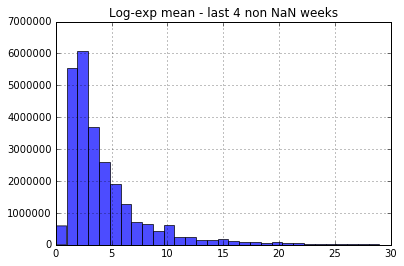

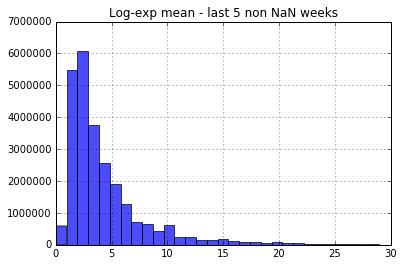

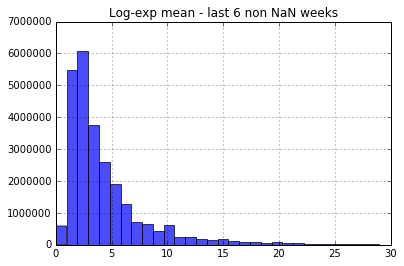

In [43]:
cutoff = 30

demand_sorted_4wk[demand_sorted_4wk < cutoff].hist(alpha=0.7, bins=cutoff);
plt.title("Log-exp mean - last 4 non NaN weeks")
plt.show()

demand_sorted_5wk[demand_sorted_5wk < cutoff].hist(alpha=0.7, bins=cutoff);
plt.title("Log-exp mean - last 5 non NaN weeks")
plt.show()

demand_sorted_6wk[demand_sorted_6wk < cutoff].hist(alpha=0.7, bins=cutoff);
plt.title("Log-exp mean - last 6 non NaN weeks")
plt.show()

They are basically identical. 

### Random forests with more variables and more data
Bring in more feautres. Tonight see if I can use 3. For a better result, I could compute the average difference in weeks demands and feed it in as another feature. I could also try standardizing all features.

In [12]:
for i, c in enumerate(df.columns):
    print(i, c)

0 Cliente_ID
1 Producto_ID
2 demand_w3
3 demand_w4
4 demand_w5
5 demand_log_mean_last6weeks


Training to predict demand for a gien week $w_i$ using the previous weeks ${w_{j<i}}$ demand. Due to memory considerations with my 8gb machine, I may have to settle for only a few feautres. In any case, it would be redundant to use more than one mean feautre.

Lets train a model to use week 3 and 4 data (plus mean) to predict week 5 demand. We are only using a fraction of the data and (mostly) ignoring weeks 5, 6, 7, 8 and 9. My idea right now is to train a set of models on different parts of the data and take averages / modes of predictions.

In [13]:
def get_features(df, features, target):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values, df[target]

In [21]:
def get_test_features(df, features):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values

In [17]:
%%time
X_train, y_train = get_features(df=df, # note: swapped to df (training on inserted demand values)
                                features=(2, 3, 5), # See above for key lookup
                                target='demand_w5')

Wall time: 323 ms


In [19]:
%%time
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)

Wall time: 39.6 s


In [38]:
for i, c in enumerate(df.columns):
    print(i, c)

0 Cliente_ID
1 Producto_ID
2 demand_w3
3 demand_w4
4 demand_w5
5 demand_log_mean_last6weeks


In [39]:
%%time
y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(2, 3, 5))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(2, 3, 5))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [02:44<00:00,  1.61it/s]

Done
Wall time: 2min 46s


In [40]:
df['demand_wk10_predict'] = y_pred

In [41]:
for i, n in enumerate(df.columns):
    print(i, n)

0 Semana
1 Cliente_ID
2 Producto_ID


In [42]:
%%time
y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(3, 6, 5))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(3, 6, 5))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

100%|████████████████████████████████████████████████████████████████████████████████| 265/265 [02:30<00:00,  1.76it/s]

Done
Wall time: 2min 32s


In [44]:
df['demand_wk11_predict'] = y_pred

In [45]:
def make_dict(df, column):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df[column])}
    return dict_client_product

dict_wk10 = make_dict(df, 'demand_wk10_predict')
dict_wk11 = make_dict(df, 'demand_wk11_predict')

In [52]:
with open('sub14_wk10dict.json', 'w') as f:
    json.dump(dict_wk10, f)

with open('sub14_wk11dict.json', 'w') as f:
    json.dump(dict_wk11, f)

In [53]:
%%time

def lookup_else_insert_mean(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict_wk10,
                     target_dict_wk11, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id, s) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                                df.Producto_ID.values,
                                                df.Semana.values))):
        if s == 10:
            val = lookup_function((c_id, p_id), target_dict_wk10)
        elif s == 11:
            val = lookup_function((c_id, p_id), target_dict_wk11)
        else:
            print('Warning unexpected behaviour')
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, lookup_else_insert_mean,
                 dict_wk10, dict_wk11,
                 '../submissions/submission_14.csv')

6999251it [52:53, 2205.80it/s] 

Wall time: 52min 53s


Can we fit __more than 3 features__ into memory for fitting?? What if we swap back to a random forest, then how many features can we use??

In [59]:
for i, d in enumerate(df.columns):
    print(i, d)

0 Cliente_ID
1 Producto_ID
2 demand_w3
3 demand_w4
4 demand_w5
5 demand_w6
6 demand_w7
7 demand_w8
8 demand_w9
9 demand_log_mean_last6weeks


In [61]:
%%time
X_train, y_train = get_features(df=df, # note: swapped to df (training on inserted demand values)
                                features=(2, 3, 4, 5, 6, 7, 9), # See above for key lookup
                                target='demand_w9')

clf = DecisionTreeClassifier(max_depth=10)
clf.fit(X_train, y_train)

Wall time: 1min 58s


### Random forest with 10 estimators, max depth 10

In [9]:
def get_features(df, features, target):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values, df[target]

In [10]:
def get_test_features(df, features):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values

In [7]:
for i, d in enumerate(df.columns):
    print(i, d)

0 Cliente_ID
1 Producto_ID
2 demand_w3
3 demand_w4
4 demand_w5
5 demand_w6
6 demand_w7
7 demand_w8
8 demand_w9
9 demand_log_mean_last6weeks


In [11]:
%%time
X_train, y_train = get_features(df=df, # note: swapped to df (training on inserted demand values)
                                features=(2, 3, 4, 5, 6, 7, 9), # See above for key lookup
                                target='demand_w9')

clf = RandomForestClassifier(n_estimators=10, max_depth=10)
clf.fit(X_train, y_train)

Wall time: 6min 42s


In [12]:
%%time

### Predict week 10

y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(3, 4, 5, 6, 7, 8, 9))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(3, 4, 5, 6, 7, 8, 9))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

df['demand_wk10_predict'] = y_pred

### Predict week 11 (using week 10 prediction as a feature)

y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(4, 5, 6, 7, 8, 10, 9))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(4, 5, 6, 7, 8, 10, 9))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

df['demand_wk11_predict'] = y_pred

### Make lookup dicts

def make_dict(df, column):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df[column])}
    return dict_client_product

dict_wk10 = make_dict(df, 'demand_wk10_predict')
dict_wk11 = make_dict(df, 'demand_wk11_predict')

### Save lookup dicts

with open('sub14_wk10dict.json', 'w') as f:
    json.dump(dict_wk10, f)

with open('sub14_wk11dict.json', 'w') as f:
    json.dump(dict_wk11, f)

### Make submission using test data

def lookup_else_insert_mean(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict_wk10,
                     target_dict_wk11, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id, s) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                                df.Producto_ID.values,
                                                df.Semana.values))):
        if s == 10:
            val = lookup_function((c_id, p_id), target_dict_wk10)
        elif s == 11:
            val = lookup_function((c_id, p_id), target_dict_wk11)
        else:
            print('Warning unexpected behaviour')
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, lookup_else_insert_mean,
                 dict_wk10, dict_wk11,
                 '../submissions/submission_15.csv')

100%|█████████████████████████████████████████████████████████████████████████████▋| 264/265 [5:35:29<01:15, 75.00s/it]

Done
Done

100%|██████████████████████████████████████████████████████████████████████████████| 265/265 [5:35:34<00:00, 53.94s/it]
6999251it [01:14, 93533.95it/s]


Wall time: 10h 46min 58s


The model above scored about equal to the 6 week log-adjusted average submission. Sooooo. Not very good. I'm in the bottom half again. I'll try adding the other features - plus one I found in a kaggle script.

### Using better features random forest with 10 trees and max depth 15

In [10]:
def get_features(df, features, target):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values, df[target]

def get_test_features(df, features):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values

In [11]:
for i, d in enumerate(df.columns):
    print(i, d)

0 Agencia_ID
1 Ruta_SAK
2 Cliente_ID
3 Producto_ID
4 demand_w5
5 demand_w6
6 demand_w7
7 demand_w8
8 demand_w9
9 demand_log_mean_last6weeks
10 NombreCliente_id


## ADJUST FEATURES BEFORE RUNNING THIS

In [ ]:
%%time 
X_train, y_train = get_features(df=df, # note: swapped to df (training on inserted demand values)
                                features=(0, 1, 4, 5, 6, 7, 9, 10), # See above for key lookup
                                target='demand_w9')

clf = RandomForestClassifier(n_estimators=10, max_depth=15)
clf.fit(X_train, y_train)

In [ ]:
%%time

### Predict week 10

y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(0, 1, 5, 6, 7, 8, 9, 10))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(0, 1, 5, 6, 7, 8, 9, 10))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

df['demand_wk10_predict'] = y_pred

### Predict week 11 (using week 10 prediction as a feature)

y_pred = []
batch = 100000
for i in tqdm(range(int(np.ceil(len(df)/batch))+1)):
    try:
        X_test = get_test_features(df=df.iloc[i*batch:(i+1)*batch],
                                        features=(0, 1, 6, 7, 8, 11, 9, 10))
    except:
        print('Final batch')
        X_test = get_test_features(df=df.iloc[i*batch:],
                                        features=(0, 1, 6, 7, 8, 11, 9, 10))
    try:
        y_pred.extend(list(clf.predict(X_test)))
    except:
        print('Done')
        
y_pred = np.array(y_pred)

df['demand_wk11_predict'] = y_pred

### Make lookup dicts

def make_dict(df, column):
    dict_client_product = {str(c)+' '+str(p): int(d) for c, p, d in
                           zip(df.Cliente_ID, df.Producto_ID, df[column])}
    return dict_client_product

dict_wk10 = make_dict(df, 'demand_wk10_predict')
dict_wk11 = make_dict(df, 'demand_wk11_predict')

### Save lookup dicts

with open('sub14_wk10dict.json', 'w') as f:
    json.dump(dict_wk10, f)

with open('sub14_wk11dict.json', 'w') as f:
    json.dump(dict_wk11, f)

### Make submission using test data

def lookup_else_insert_mean(x, target_dict):
    c_id, p_id = x
    try:
        val = target_dict[str(c_id)+' '+str(p_id)]
    except:
        val = dict_product_mean[p_id]
    return val

def write_submission(df, lookup_function, target_dict_wk10,
                     target_dict_wk11, file):
    f = open(file, 'w')
    f.write('id,Demanda_uni_equil\n')
    for i, (c_id, p_id, s) in tqdm(enumerate(zip(df.Cliente_ID.values,
                                                df.Producto_ID.values,
                                                df.Semana.values))):
        if s == 10:
            val = lookup_function((c_id, p_id), target_dict_wk10)
        elif s == 11:
            val = lookup_function((c_id, p_id), target_dict_wk11)
        else:
            print('Warning unexpected behaviour')
            val = overall_mean
        f.write(str(i)+','+str(val)+'\n')
    f.close()

write_submission(df_test, lookup_else_insert_mean,
                 dict_wk10, dict_wk11,
                 '../submissions/submission_16.csv')

Using __larger training sets by extracting properly from df__. This is hard-coded for a given set of features. Below we consider the previous two weeks of lag for demand plus the average.

In [58]:
for i, c in enumerate(df.columns):
    print(i, c)

0 Cliente_ID
1 Producto_ID
2 demand_w3
3 demand_w4
4 demand_w5
5 demand_w6
6 demand_w7
7 demand_w8
8 demand_w9
9 demand_log_mean_last6weeks


In [ ]:
def get_features(df, features, target):
    ''' Return numpy array of values. '''
    return df.iloc[:, features].values, df[target]

In [ ]:
%%time
# Aggregate training data for two week lagged predictions
X_train, y_train = get_features(df=df, # note: swapped to df (training on inserted demand values)
                                features=(2, 3, 9), # See above for key lookup
                                target='demand_w5')

X, y = get_features(df=df, # note: swapped to df (training on inserted demand values)
                    features=(3, 4, 9), # See above for key lookup
                    target='demand_w6')
X_train = np.concatenate((X_train, X))
y_train = np.concatenate((y_train, y))

X, y = get_features(df=df,
                    features=(4, 5, 9), # See above for key lookup
                    target='demand_w7')
X_train = np.concatenate((X_train, X))
y_train = np.concatenate((y_train, y))

X, y = get_features(df=df,
                    features=(5, 6, 9), # See above for key lookup
                    target='demand_w8')
X_train = np.concatenate((X_train, X))
y_train = np.concatenate((y_train, y))

X, y = get_features(df=df,
                    features=(6, 7, 9), # See above for key lookup
                    target='demand_w9')
X_train = np.concatenate((X_train, X))
y_train = np.concatenate((y_train, y))

In [57]:
np.concatenate((a, b))

array([[1, 2, 3],
       [5, 5, 6],
       [1, 2, 1],
       [3, 3, 3],
       [5, 4, 6],
       [4, 2, 4]])